## Latar Belakang

Latar Belakang Program: Mewarnai Foto-Foto Zaman Dahulu
Seiring dengan perkembangan teknologi, kita telah menyaksikan kemajuan yang luar biasa dalam bidang pengolahan citra digital. Salah satu aplikasi menarik dari teknologi ini adalah kemampuan untuk mewarnai foto-foto hitam putih dari masa lalu. Foto-foto hitam putih memiliki nilai sejarah yang tinggi dan sering kali menjadi satu-satunya jendela kita ke masa lalu. Namun, foto-foto ini sering kali kurang mampu menyampaikan detail dan nuansa yang ada pada saat itu karena ketiadaan warna.

Program ini dirancang untuk mengatasi keterbatasan tersebut dengan menggunakan teknologi Generative Adversarial Networks (GANs) untuk mewarnai foto-foto hitam putih. Dengan mewarnai foto-foto ini, kita tidak hanya memberikan warna pada gambar, tetapi juga menghidupkan kembali momen-momen berharga dari masa lalu dengan detail yang lebih kaya dan realistis.

## Tujuan

Menghidupkan Kembali Kenangan: Memberikan warna pada foto-foto hitam putih sehingga momen-momen berharga dari masa lalu dapat dilihat dengan lebih hidup dan nyata.
Meningkatkan Detail Gambar: Menghasilkan gambar berwarna dengan detail yang lebih baik, sehingga informasi visual yang terkandung dalam foto dapat disampaikan dengan lebih jelas.
Preservasi Sejarah: Membantu dalam upaya preservasi sejarah dengan memberikan konteks visual yang lebih kaya pada foto-foto bersejarah.

## Install Libraries

In [ ]:
!pip install torch torchvision scikit-image matplotlib tqdm pillow kagglehub torchmetrics clean-fid

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 28.6 MB/s eta 0:00:00


## Import Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os
from PIL import Image
import kagglehub
from torchmetrics.image.fid import FrechetInceptionDistance
from torchvision.utils import save_image
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_
from torch.optim.lr_scheduler import CosineAnnealingLR
from cleanfid import fid
import shutil
import random

## Define Dataset

In [ ]:
class ColorizationDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = os.listdir(image_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        gray_image = transforms.Grayscale()(image)
        return gray_image, image

## Define Discriminator & Generator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # Input: 3 x 256 x 256
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  # 64 x 128 x 128
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 128 x 64 x 64
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 256 x 32 x 32
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # 512 x 16 x 16
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, kernel_size=4, stride=2, padding=1),  # 1 x 8 x 8
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x



## Compute Loss Function

In [ ]:
def compute_loss(discriminator, generator_outputs, real_images, device):
    batch_size = real_images.size(0)
    valid = torch.ones((batch_size, 1, 8, 8), requires_grad=False).to(device)
    fake = torch.zeros((batch_size, 1, 8, 8), requires_grad=False).to(device)

    gen_fake = discriminator(generator_outputs)
    g_loss_gan = 0.1 * F.binary_cross_entropy(gen_fake, valid)
    g_loss_l1 = 10.0 * F.l1_loss(generator_outputs, real_images)
    g_loss_mse = F.mse_loss(generator_outputs, real_images)

    g_loss = g_loss_gan + g_loss_l1 + g_loss_mse

    real_target = torch.ones_like(valid).uniform_(0.8, 1.0)
    fake_target = torch.zeros_like(fake).uniform_(0.0, 0.2)

    real_pred = discriminator(real_images)
    fake_pred = discriminator(generator_outputs.detach())

    real_loss = F.binary_cross_entropy(real_pred, real_target)
    fake_loss = F.binary_cross_entropy(fake_pred, fake_target)
    d_loss = (real_loss + fake_loss) / 2

    return g_loss, d_loss

## Evaluating Image Similarity

In [ ]:
def calculate_ssim(predicted, ground_truth):
    """Calculate SSIM with proper dimensionality and normalization"""
    # Ensure images are in range [0,1] and correct format
    predicted_np = ((predicted.cpu().numpy().transpose(1, 2, 0) + 1) / 2).clip(0, 1)
    ground_truth_np = ((ground_truth.cpu().numpy().transpose(1, 2, 0) + 1) / 2).clip(0, 1)

    # Calculate SSIM with explicit window size
    return ssim(
        predicted_np,
        ground_truth_np,
        win_size=3,  # Smaller window size
        multichannel=True,
        channel_axis=2,  # Specify channel axis
        data_range=1.0
    )

## Define Training Func

In [ ]:
def train(generator, discriminator, dataloader, g_optimizer, d_optimizer, device, num_epochs=20, save_dir="checkpoints"):
    os.makedirs(save_dir, exist_ok=True)
    best_ssim = 0

    g_scheduler = CosineAnnealingLR(g_optimizer, T_max=num_epochs, eta_min=1e-6)
    d_scheduler = CosineAnnealingLR(d_optimizer, T_max=num_epochs, eta_min=1e-6)

    for epoch in range(num_epochs):
        generator.train()
        discriminator.train()
        running_g_loss = 0.0
        running_d_loss = 0.0
        n_samples = 0

        progress_bar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for i, (gray_images, color_images) in enumerate(progress_bar):
            batch_size = gray_images.size(0
                                          )
            n_samples += batch_size

            # Normalize inputs to [-1, 1]
            gray_images = (gray_images * 2) - 1
            color_images = (color_images * 2) - 1

            gray_images = gray_images.to(device)
            real_images = color_images.to(device)

            # Train Generator
            g_optimizer.zero_grad()
            gen_output = generator(gray_images)
            g_loss, _ = compute_loss(discriminator, gen_output, real_images, device)
            g_loss.backward()
            clip_grad_norm_(generator.parameters(), max_norm=1.0)
            g_optimizer.step()

            running_g_loss += g_loss.item() * batch_size

            # Train Discriminator only every 2 iterations
            if i % 2 == 0:
                d_optimizer.zero_grad()
                _, d_loss = compute_loss(discriminator, gen_output.detach(), real_images, device)
                d_loss.backward()
                clip_grad_norm_(discriminator.parameters(), max_norm=1.0)
                d_optimizer.step()
                running_d_loss += d_loss.item() * batch_size

            # Update progress bar
            progress_bar.set_postfix({
                'G_loss': f'{g_loss.item():.4f}',
                'D_loss': f'{d_loss.item():.4f}' if i % 2 == 0 else 'skipped'
            })

        # Calculate epoch averages
        avg_g_loss = running_g_loss / n_samples
        avg_d_loss = running_d_loss / n_samples
        print(f"Epoch [{epoch + 1}/{num_epochs}] avg_g_loss: {avg_g_loss:.4f}, avg_d_loss: {avg_d_loss:.4f}")

        # Update learning rates
        g_scheduler.step()
        d_scheduler.step()

        # Validation and model saving
        if (epoch + 1) % 5 == 0:  # Validate every 5 epochs
            generator.eval()
            with torch.no_grad():
                sample_output = generator(gray_images[:1])
                current_ssim = calculate_ssim(sample_output[0], real_images[0])

                if current_ssim > best_ssim:
                    best_ssim = current_ssim
                    torch.save({
                        'generator_state_dict': generator.state_dict(),
                        'discriminator_state_dict': discriminator.state_dict(),
                        'epoch': epoch,
                        'ssim': best_ssim,
                        'g_optimizer_state_dict': g_optimizer.state_dict(),
                        'd_optimizer_state_dict': d_optimizer.state_dict(),
                    }, os.path.join(save_dir, "best_model.pth"))

                # Save sample image
                sample_output = (sample_output[0].cpu().permute(1, 2, 0).numpy() + 1) / 2
                plt.imsave(f"{save_dir}/sample_epoch_{epoch + 1}.png", sample_output.clip(0, 1))


## Model Loading and Prediction

In [ ]:
def load_model(model_path, device):
    model = Generator().to(device)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['generator_state_dict'])
    model.eval()
    return model

In [ ]:
def predict_color(model, gray_image, device):
    model.eval()
    with torch.no_grad():
        gray_tensor = transforms.ToTensor()(gray_image).unsqueeze(0).to(device)
        output = model(gray_tensor)
        colored_image = output[0].cpu()
        colored_image = (colored_image + 1) / 2  # Denormalize
        return colored_image

## Execution

In [ ]:
# Main Script
if __name__ == "__main__":
    # Hyperparameters
    path = kagglehub.dataset_download("aayush9753/image-colorization-dataset")
    BASE_LINK = os.path.join(path, 'data/train_color')
    print("Path to dataset files:", BASE_LINK)

    image_dir = BASE_LINK
    batch_size = 32
    lr = 0.0001
    num_epochs = 30
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Data Preparation
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Added color augmentation
        transforms.ToTensor(),
    ])

    dataset = ColorizationDataset(image_dir, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Model, Loss, Optimizer
    generator = Generator().to(device)
    discriminator = Discriminator().to(device)

    # Optimizers
    g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

    # Training with GAN
    train(generator, discriminator, dataloader, g_optimizer, d_optimizer, device, num_epochs)

100%|██████████| 473M/473M [00:21<00:00, 22.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/aayush9753/image-colorization-dataset/versions/1/data/train_color


Epoch 1/30: 100%|██████████| 157/157 [01:48<00:00,  1.45it/s, G_loss=1.7108, D_loss=0.6888]


Epoch [1/30] avg_g_loss: 2.1014, avg_d_loss: 0.2599


Epoch 2/30: 100%|██████████| 157/157 [01:49<00:00,  1.44it/s, G_loss=2.2778, D_loss=0.6331]


Epoch [2/30] avg_g_loss: 1.7572, avg_d_loss: 0.2661


Epoch 3/30: 100%|██████████| 157/157 [01:52<00:00,  1.40it/s, G_loss=1.3636, D_loss=0.7862]


Epoch [3/30] avg_g_loss: 1.7607, avg_d_loss: 0.2537


Epoch 4/30: 100%|██████████| 157/157 [01:48<00:00,  1.45it/s, G_loss=1.7280, D_loss=0.4249]


Epoch [4/30] avg_g_loss: 1.7452, avg_d_loss: 0.2881


Epoch 5/30: 100%|██████████| 157/157 [01:47<00:00,  1.46it/s, G_loss=1.9054, D_loss=0.3909]


Epoch [5/30] avg_g_loss: 1.7064, avg_d_loss: 0.2997


Epoch 6/30: 100%|██████████| 157/157 [01:47<00:00,  1.46it/s, G_loss=2.3062, D_loss=0.3627]


Epoch [6/30] avg_g_loss: 1.6903, avg_d_loss: 0.2925


Epoch 7/30: 100%|██████████| 157/157 [01:47<00:00,  1.46it/s, G_loss=1.6896, D_loss=0.7655]


Epoch [7/30] avg_g_loss: 1.6576, avg_d_loss: 0.2900


Epoch 8/30: 100%|██████████| 157/157 [01:48<00:00,  1.44it/s, G_loss=2.1030, D_loss=0.4401]


Epoch [8/30] avg_g_loss: 1.6533, avg_d_loss: 0.3110


Epoch 9/30: 100%|██████████| 157/157 [01:48<00:00,  1.44it/s, G_loss=1.9763, D_loss=0.5999]


Epoch [9/30] avg_g_loss: 1.6404, avg_d_loss: 0.3126


Epoch 10/30: 100%|██████████| 157/157 [01:48<00:00,  1.45it/s, G_loss=1.4606, D_loss=1.1104]


Epoch [10/30] avg_g_loss: 1.6156, avg_d_loss: 0.3025


Epoch 11/30: 100%|██████████| 157/157 [01:48<00:00,  1.44it/s, G_loss=1.7035, D_loss=0.5205]


Epoch [11/30] avg_g_loss: 1.6095, avg_d_loss: 0.2992


Epoch 12/30: 100%|██████████| 157/157 [01:48<00:00,  1.45it/s, G_loss=2.0378, D_loss=0.4910]


Epoch [12/30] avg_g_loss: 1.6045, avg_d_loss: 0.2912


Epoch 13/30: 100%|██████████| 157/157 [01:48<00:00,  1.45it/s, G_loss=1.3748, D_loss=0.9144]


Epoch [13/30] avg_g_loss: 1.5988, avg_d_loss: 0.2941


Epoch 14/30: 100%|██████████| 157/157 [01:48<00:00,  1.45it/s, G_loss=1.6338, D_loss=1.2044]


Epoch [14/30] avg_g_loss: 1.5863, avg_d_loss: 0.2807


Epoch 15/30: 100%|██████████| 157/157 [01:48<00:00,  1.44it/s, G_loss=1.5659, D_loss=0.4089]


Epoch [15/30] avg_g_loss: 1.5714, avg_d_loss: 0.2916


Epoch 16/30: 100%|██████████| 157/157 [01:47<00:00,  1.45it/s, G_loss=1.3304, D_loss=1.9124]


Epoch [16/30] avg_g_loss: 1.5732, avg_d_loss: 0.2835


Epoch 17/30: 100%|██████████| 157/157 [01:48<00:00,  1.45it/s, G_loss=1.7924, D_loss=0.4115]


Epoch [17/30] avg_g_loss: 1.5685, avg_d_loss: 0.2772


Epoch 18/30: 100%|██████████| 157/157 [01:48<00:00,  1.45it/s, G_loss=1.2639, D_loss=1.2523]


Epoch [18/30] avg_g_loss: 1.5634, avg_d_loss: 0.2738


Epoch 19/30: 100%|██████████| 157/157 [01:48<00:00,  1.45it/s, G_loss=2.2817, D_loss=0.5604]


Epoch [19/30] avg_g_loss: 1.5625, avg_d_loss: 0.2786


Epoch 20/30: 100%|██████████| 157/157 [01:47<00:00,  1.46it/s, G_loss=1.7294, D_loss=0.3631]


Epoch [20/30] avg_g_loss: 1.5657, avg_d_loss: 0.2744


Epoch 21/30: 100%|██████████| 157/157 [01:48<00:00,  1.44it/s, G_loss=1.4268, D_loss=1.2226]


Epoch [21/30] avg_g_loss: 1.5732, avg_d_loss: 0.2789


Epoch 22/30: 100%|██████████| 157/157 [01:47<00:00,  1.46it/s, G_loss=1.6963, D_loss=0.4727]


Epoch [22/30] avg_g_loss: 1.5674, avg_d_loss: 0.2640


Epoch 23/30: 100%|██████████| 157/157 [01:48<00:00,  1.45it/s, G_loss=1.7506, D_loss=0.5973]


Epoch [23/30] avg_g_loss: 1.5590, avg_d_loss: 0.2637


Epoch 24/30: 100%|██████████| 157/157 [01:47<00:00,  1.45it/s, G_loss=1.3879, D_loss=0.4198]


Epoch [24/30] avg_g_loss: 1.5620, avg_d_loss: 0.2656


Epoch 25/30: 100%|██████████| 157/157 [01:48<00:00,  1.45it/s, G_loss=1.2371, D_loss=0.8173]


Epoch [25/30] avg_g_loss: 1.5580, avg_d_loss: 0.2669


Epoch 26/30: 100%|██████████| 157/157 [01:48<00:00,  1.45it/s, G_loss=1.4784, D_loss=0.6220]


Epoch [26/30] avg_g_loss: 1.5511, avg_d_loss: 0.2507


Epoch 27/30: 100%|██████████| 157/157 [01:48<00:00,  1.45it/s, G_loss=1.8552, D_loss=0.3940]


Epoch [27/30] avg_g_loss: 1.5758, avg_d_loss: 0.2571


Epoch 28/30: 100%|██████████| 157/157 [01:47<00:00,  1.45it/s, G_loss=1.5848, D_loss=0.3887]


Epoch [28/30] avg_g_loss: 1.5651, avg_d_loss: 0.2686


Epoch 29/30: 100%|██████████| 157/157 [01:49<00:00,  1.44it/s, G_loss=1.4465, D_loss=1.0712]


Epoch [29/30] avg_g_loss: 1.5527, avg_d_loss: 0.2528


Epoch 30/30: 100%|██████████| 157/157 [01:52<00:00,  1.39it/s, G_loss=1.6277, D_loss=0.5710]

Epoch [30/30] avg_g_loss: 1.5486, avg_d_loss: 0.2568


In [ ]:
def load_model(model_path, device):
    model = Generator().to(device)
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['generator_state_dict'])
    model.eval()
    return model

def calculate_ssim(predicted, ground_truth):
    predicted = predicted.to(device)
    ground_truth = ground_truth.to(device)

    if predicted.dim() == 4:
        predicted = predicted.squeeze(0)
        ground_truth = ground_truth.squeeze(0)

    # Normalize on GPU
    predicted = ((predicted + 1) / 2).clamp(0, 1)
    ground_truth = ((ground_truth + 1) / 2).clamp(0, 1)

    # Convert to numpy only at final step
    predicted_np = predicted.cpu().numpy().transpose(1, 2, 0)
    ground_truth_np = ground_truth.cpu().numpy().transpose(1, 2, 0)

    return ssim(
        predicted_np,
        ground_truth_np,
        win_size=3,
        multichannel=True,
        channel_axis=2,
        data_range=1.0
    )

def evaluate_model(model, test_dataloader, device):
    model.eval()
    total_ssim = 0
    num_samples = 0

    # Create temporary directories
    real_dir = "temp_real_images"
    fake_dir = "temp_fake_images"
    os.makedirs(real_dir, exist_ok=True)
    os.makedirs(fake_dir, exist_ok=True)

    with torch.no_grad():
        for idx, (gray_images, color_images) in enumerate(tqdm(test_dataloader, desc="Evaluating")):
            # Move to device and generate outputs
            gray_images = gray_images.to(device)
            color_images = color_images.to(device)

            # Generate colorized images
            outputs = model(gray_images)

            # Process each image in batch
            for j in range(outputs.size(0)):
                # Get single images and ensure RGB format
                pred = outputs[j]  # Already in RGB
                true = color_images[j]  # Convert to RGB if needed
                if true.size(0) == 2:  # If LAB format
                    true = torch.cat([gray_images[j], true], dim=0)  # Combine L and ab channels

                # Normalize to [0,1]
                pred = ((pred + 1) / 2).clamp(0, 1)
                true = ((true + 1) / 2).clamp(0, 1)

                # Convert to numpy arrays
                pred_np = pred.cpu().numpy().transpose(1, 2, 0)
                true_np = true.cpu().numpy().transpose(1, 2, 0)

                # Calculate SSIM
                ssim_val = ssim(pred_np, true_np,
                               data_range=1.0,
                               channel_axis=2,
                               multichannel=True)
                total_ssim += ssim_val
                num_samples += 1

                # Save images for FID
                save_image(pred, f"{fake_dir}/{idx}_{j}.png")
                save_image(true, f"{real_dir}/{idx}_{j}.png")

    # Calculate metrics
    avg_ssim = total_ssim / num_samples
    fid_score = fid.compute_fid(real_dir, fake_dir)

    # Cleanup
    shutil.rmtree(real_dir)
    shutil.rmtree(fake_dir)

    return avg_ssim, fid_score

In [ ]:
# After training, add testing code
test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
# Create test dataset
test_dataset = ColorizationDataset(os.path.join(path, 'data/test_color'), transform=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# Load best model
best_model_path = os.path.join("checkpoints", "best_model.pth")

model = load_model(best_model_path, device)
# Evaluate model
print("Evaluating model...")
ssim_score, fid_score = evaluate_model(model, test_dataloader, device)
print(f"Average SSIM: {ssim_score:.4f}")
print(f"FID Score: {fid_score:.4f}")
# Example of single image prediction
test_image_path = os.path.join(path, 'data/test_color', os.listdir(os.path.join(path, 'data/test_color'))[0])
gray_image = Image.open(test_image_path).convert('L')
colored_output = predict_color(model, gray_image, device)

# Save the result
save_image(colored_output, "predicted_color.png")

Evaluating model...


Evaluating: 100%|██████████| 24/24 [00:56<00:00,  2.34s/it]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


compute FID between two folders
Found 739 images in the folder temp_real_images


FID temp_real_images : 100%|██████████| 24/24 [00:18<00:00,  1.27it/s]


Found 739 images in the folder temp_fake_images


FID temp_fake_images : 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


Average SSIM: 0.7929
FID Score: 151.5557


## Display Output

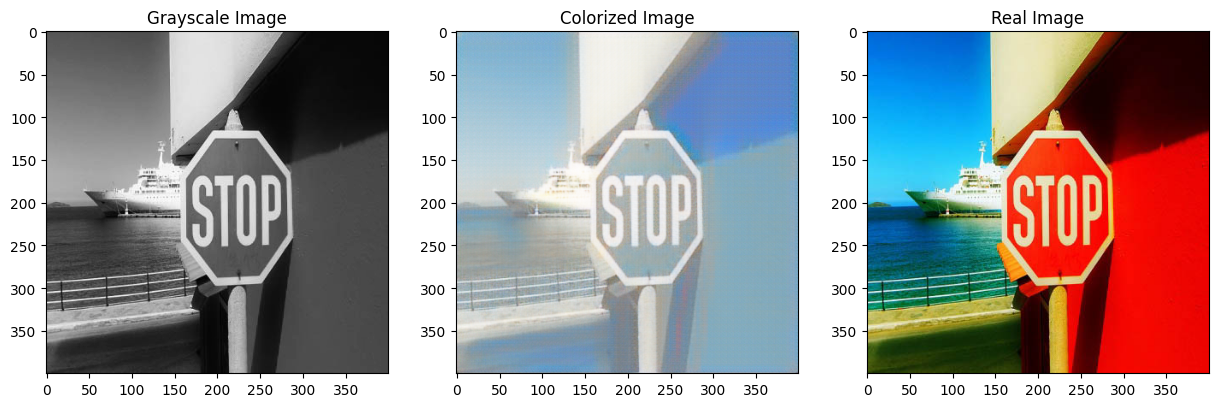

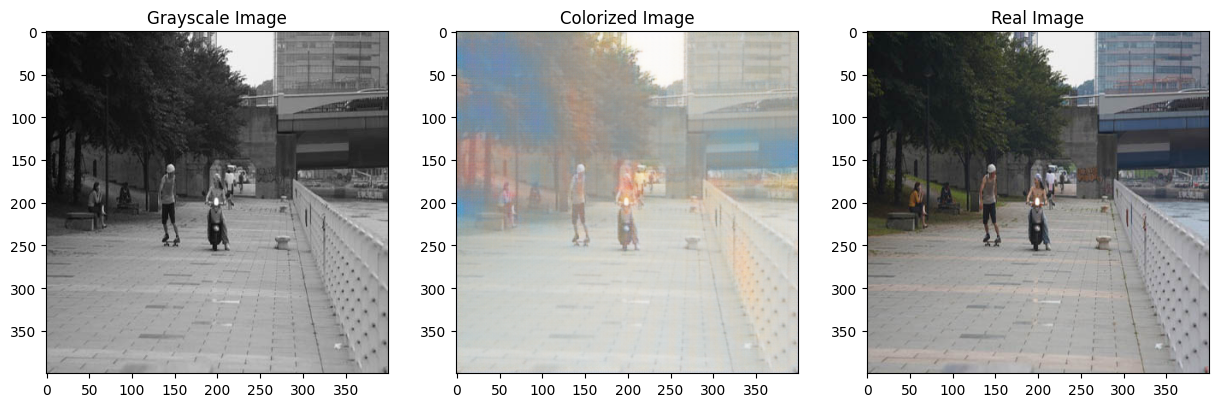

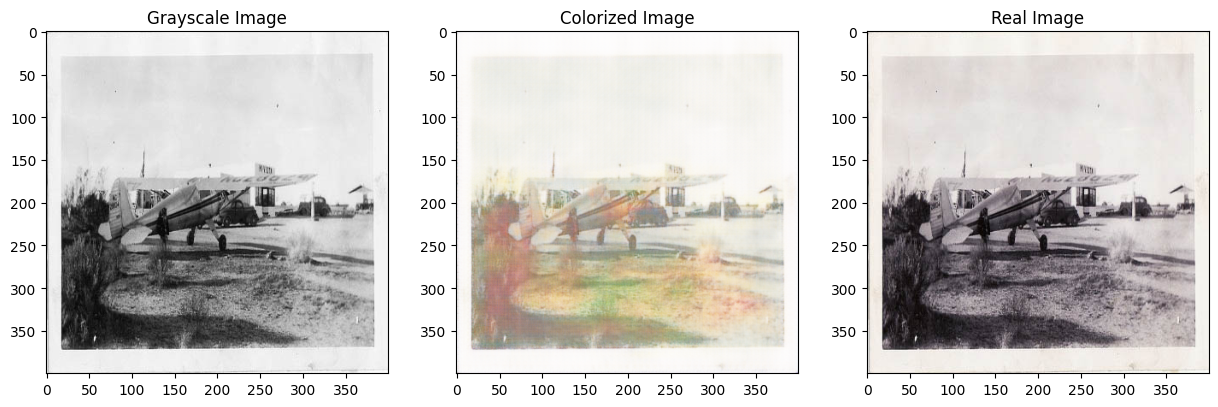

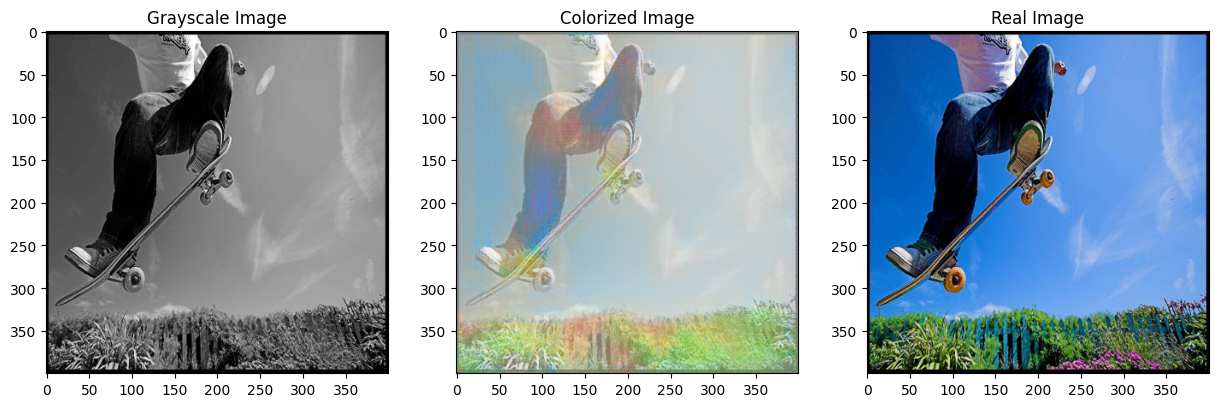

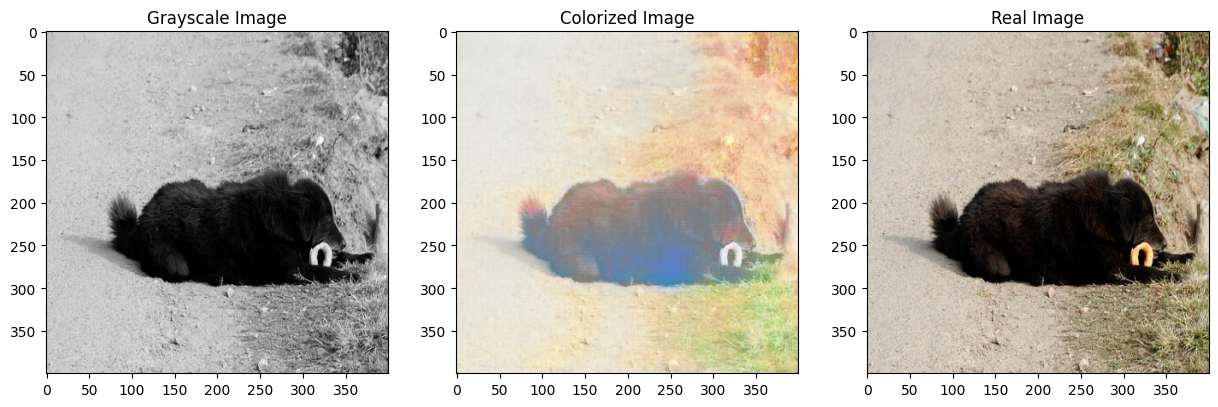

In [ ]:
# Function to display images
def display_images(real_image_path, grayscale_image, colorized_image):
    plt.figure(figsize=(15, 5))

    # Display grayscale image
    plt.subplot(1, 3, 1)
    plt.imshow(grayscale_image, cmap='gray')
    plt.title("Grayscale Image")

    # Display the colorized output
    plt.subplot(1, 3, 2)
    plt.imshow(colorized_image)
    plt.title("Colorized Image")

    # Display the real image
    plt.subplot(1, 3, 3)
    real_image = Image.open(real_image_path)
    plt.imshow(real_image)
    plt.title("Real Image")

    plt.show()

# Get 5 random images from the test set
test_image_dir = os.path.join(path, 'data/test_color')
random_image_names = random.sample(os.listdir(test_image_dir), 5)

for image_name in random_image_names:
    test_image_path = os.path.join(test_image_dir, image_name)

    # Open the image and convert it to grayscale
    gray_image = Image.open(test_image_path).convert('L')

    # Predict colorization
    colored_output = predict_color(model, gray_image, device)

    # Display images
    display_images(test_image_path, gray_image, colored_output.permute(1, 2, 0))